In [1]:
%cd ../..

/Users/eli/AnacondaProjects/oscillapy


In [2]:
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io as sio

import src.oscillapy as oscpy

In [3]:
%matplotlib inline

In [4]:
data = sio.loadmat('/Users/eli/Documents/Data/LabAssignment/data.mat', simplify_cells=True, struct_as_record=False)

/Users/eli/miniforge3/envs/ephys/lib/python3.11/site-packages/scipy/io/matlab/_mio.py:227: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


In [5]:
electrode_info = pd.read_csv('/Users/eli/Documents/Data/LabAssignment/electrodeInfo.csv')

In [6]:
trial_info = pd.read_csv('/Users/eli/Documents/Data/LabAssignment/trialInfo.csv')

In [7]:
dt = data['lfpSchema']['smpInterval'][0]

In [8]:
times = data['lfpSchema']['index'][0]

In [9]:
good_trials = np.nonzero(trial_info['badTrials'].to_numpy() == 0)[0]

In [10]:
lfp = oscpy.signals.lfp.LocalFieldPotential(electrode_info, data['lfp'].swapaxes(0, 1), dt, times)

In [11]:
events = collections.OrderedDict({
    'trialStart': None,
    'fixptOn': None,
    'fixationTime': None,
    'sampleOn': None,
    'sampleOff': None,
    'testOn': None,
    'responseDone': None,
})

for event in events:
    events[event] = trial_info[event].to_numpy()

In [12]:
events = pd.DataFrame(data=events)

In [13]:
recording = oscpy.recording.Recording(events, trial_info, lfp=lfp)

In [14]:
trials = recording.select_trials(lambda row: row == 0, 'badTrials')

In [15]:
cued_lfp = trials.time_lock('sampleOn', duration=0.5, before=0.5).signals['lfp']

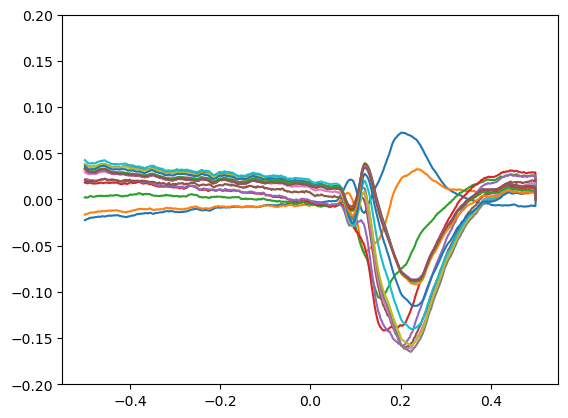

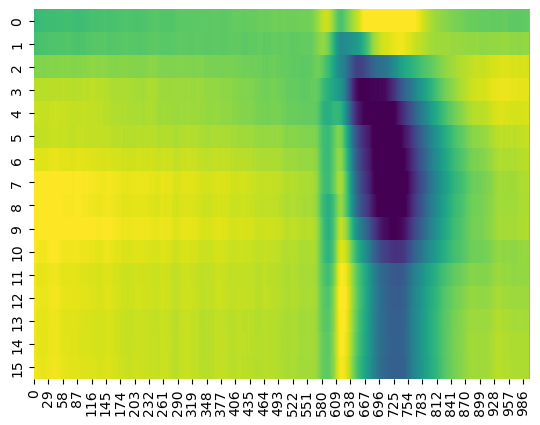

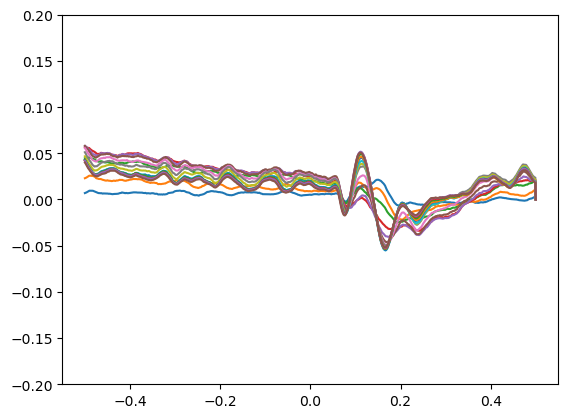

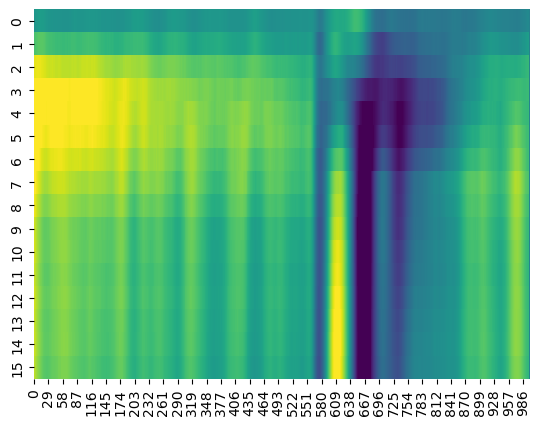

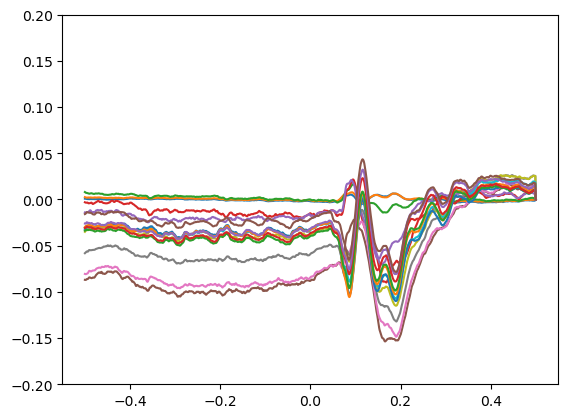

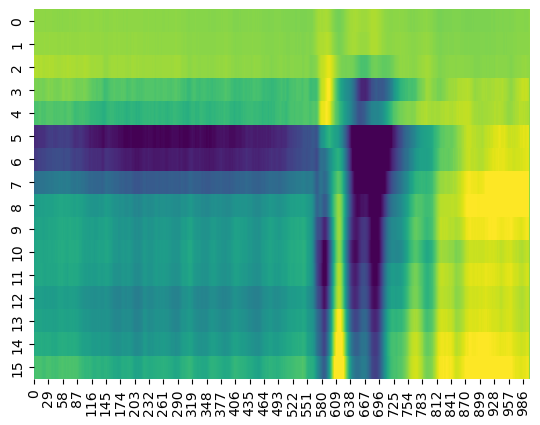

In [16]:
for area in ['VLPFC1', '7A', 'V4 Foveal']:
    lfp = cued_lfp.select_channels('area', area)
    erp = lfp.erp()

    ax = plt.gca()
    erp.plot()
    ax.set_ylim(bottom=-0.2, top=0.2)
    plt.show()

    erp.heatmap()
    plt.show()

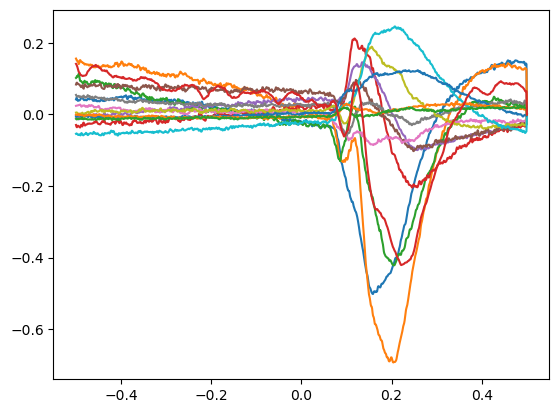

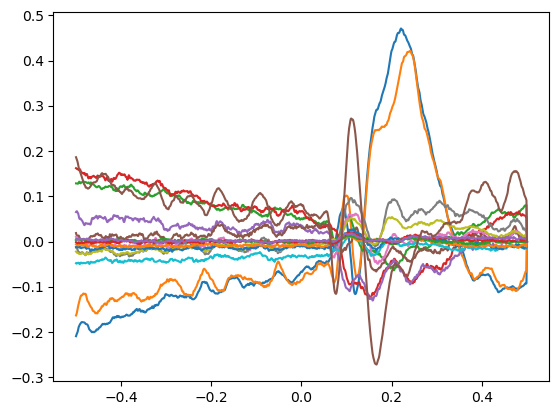

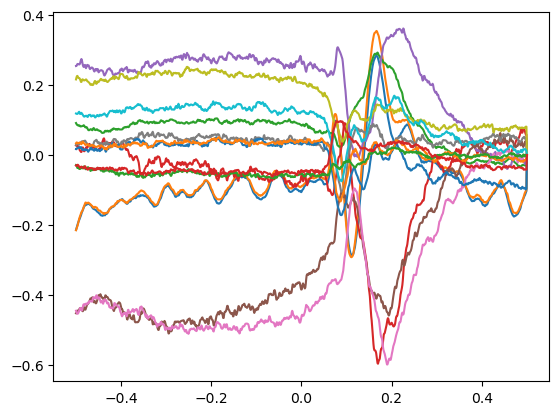

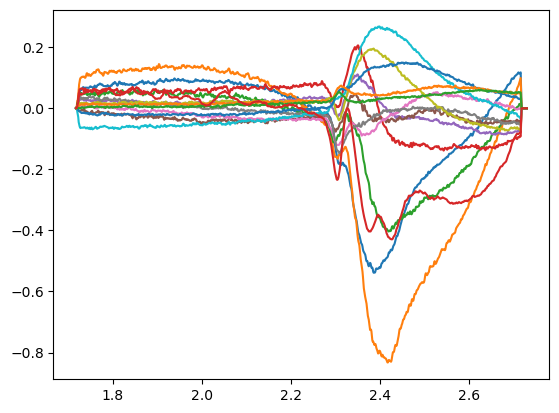

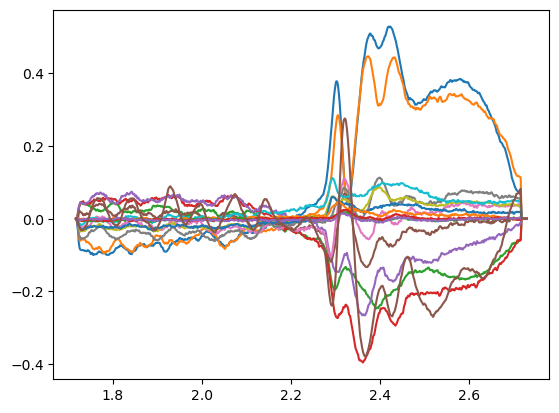

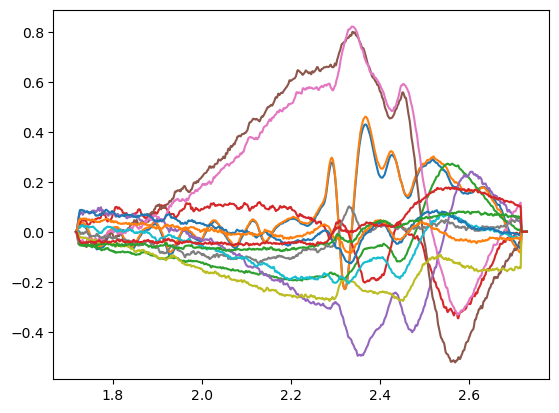

In [17]:
for event in ['sampleOn', 'testOn']:
    event_csds = trials.time_lock(event, duration=0.5, before=0.5).signals['lfp'].csd(0.4, 0.2)
    for area in ['VLPFC1', '7A', 'V4 Foveal']:
        csd = event_csds.select_channels('area', area).erp()
        csd.plot()
        ax = plt.gca()
        # ax.set_ylim(bottom=-0.2, top=0.2)
        plt.show()

## 1 second pre-sample-onset to 1 second post-sample-onset (samples 501-2500)

In [18]:
cued_lfp = trials.time_lock('sampleOn', duration=1., before=1.).signals['lfp']

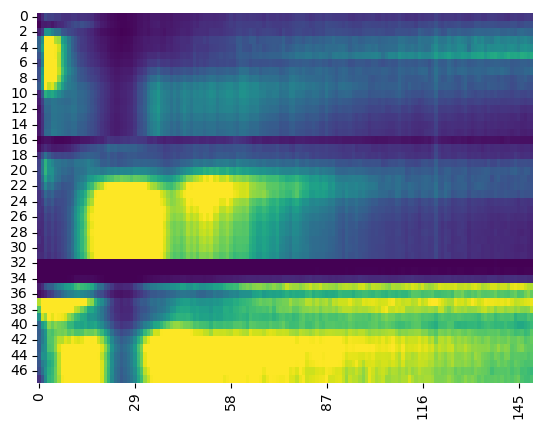

In [19]:
spectrum = cued_lfp.power_spectrum(dBs=False, relative=True, taper=np.hanning)
spectrum.heatmap(fbottom=0., ftop=150.)

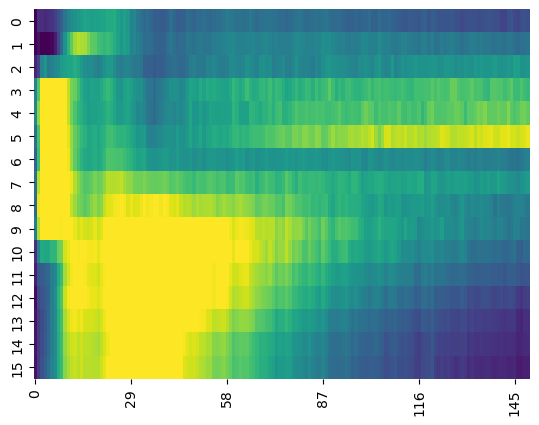

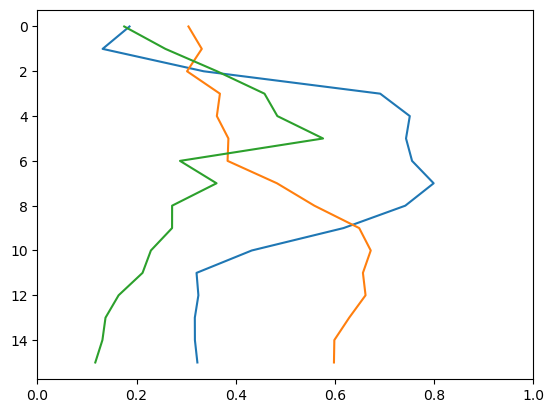

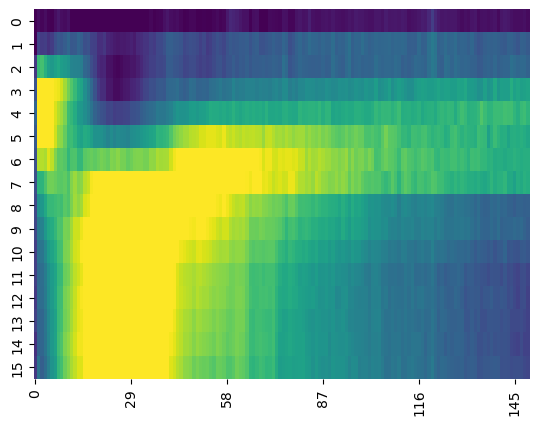

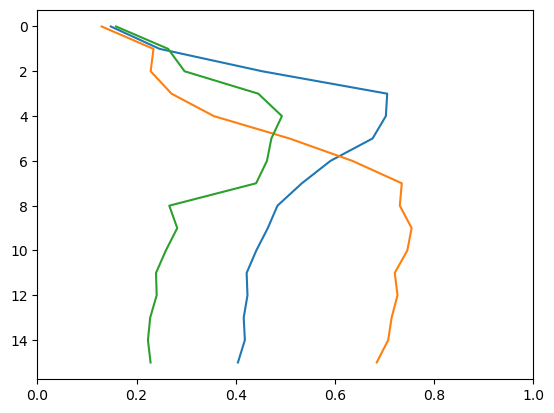

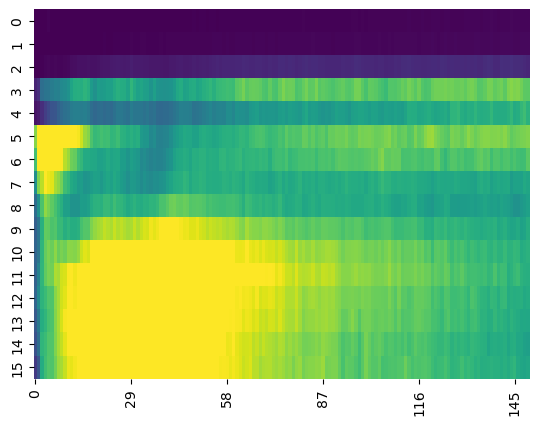

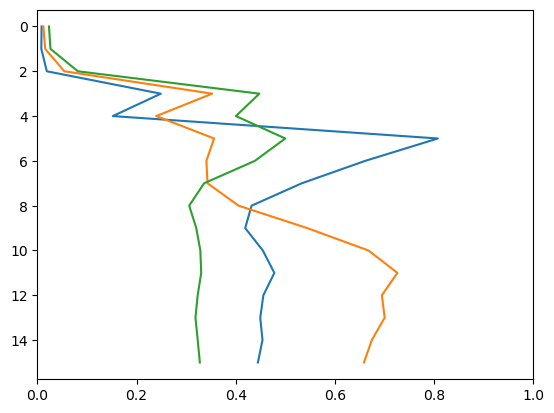

In [20]:
for area in ['VLPFC1', '7A', 'V4 Foveal']:
    lfp = cued_lfp.select_channels('area', area)
    spectrum = lfp.power_spectrum(dBs=False, relative=True, taper=np.hanning)
    spectrum.heatmap(fbottom=0., ftop=150.)
    plt.show()

    band_powers = [spectrum.band_power(*oscpy.spectrum.THETA_BAND),
                   spectrum.band_power(*oscpy.spectrum.ALPHA_BETA_BAND),
                   spectrum.band_power(*oscpy.spectrum.GAMMA_BAND)]

    for band in band_powers:
        spectrum.plot_channels(band, xlims=(0., 1.))
    plt.show()

In [21]:
sampleOns = trials.time_lock('sampleOn', duration=1., before=1.)

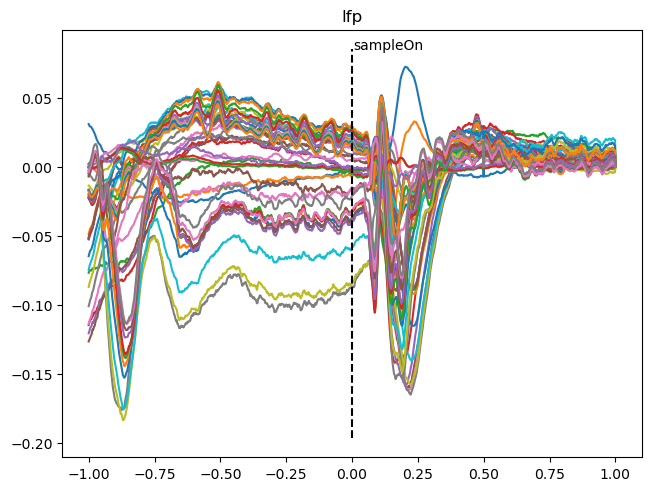

In [22]:
sampleOns.plot_trial()